In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from haversine import haversine
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("/kaggle/input/california-housing-prices/housing.csv")

In [3]:
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
((df.isna().sum()*100/df.shape[0]).round(2)).astype('str')+"%"

longitude             0.0%
latitude              0.0%
housing_median_age    0.0%
total_rooms           0.0%
total_bedrooms        1.0%
population            0.0%
households            0.0%
median_income         0.0%
median_house_value    0.0%
ocean_proximity       0.0%
dtype: object

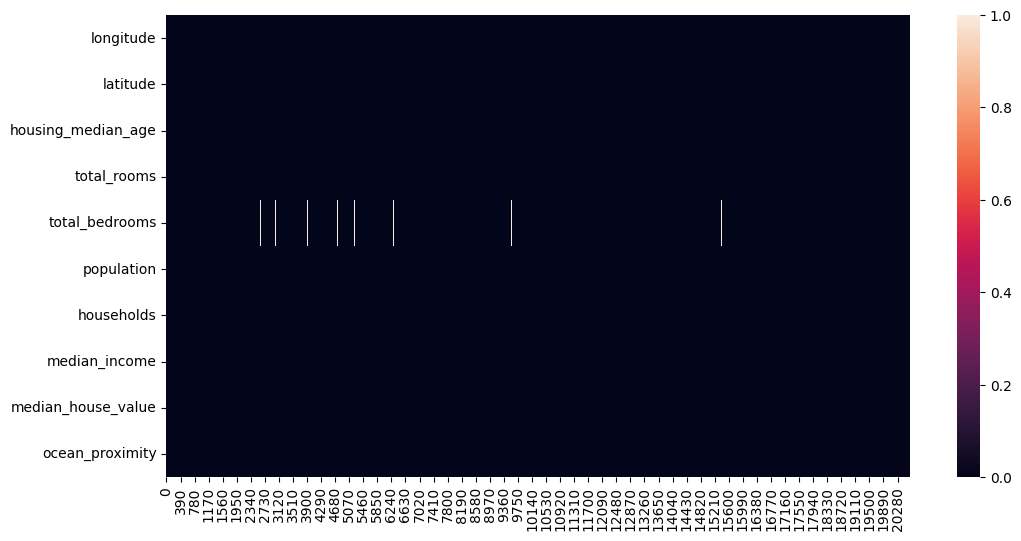

In [7]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isna().T)
plt.show()

In [8]:
#Filling the Missing Values using KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_d = df.copy()
ocean_proximity = df_d[['ocean_proximity']]
df_d.drop(columns=['ocean_proximity'],inplace = True)
encoder = OneHotEncoder(sparse_output=False,)
encoded_df = encoder.fit_transform(ocean_proximity,)
encoded_data = pd.DataFrame(encoded_df, columns=encoder.get_feature_names_out())
df_e = pd.concat([df_d, encoded_data], axis=1)

dfi = pd.DataFrame(imputer.fit_transform(df_e),columns=df_e.columns)
df['total_bedrooms'] = dfi['total_bedrooms'].copy()

In [9]:
df[['ocean_proximity']]

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY
...,...
20635,INLAND
20636,INLAND
20637,INLAND
20638,INLAND


In [10]:
df_num = df.select_dtypes(include=['float64']).copy()

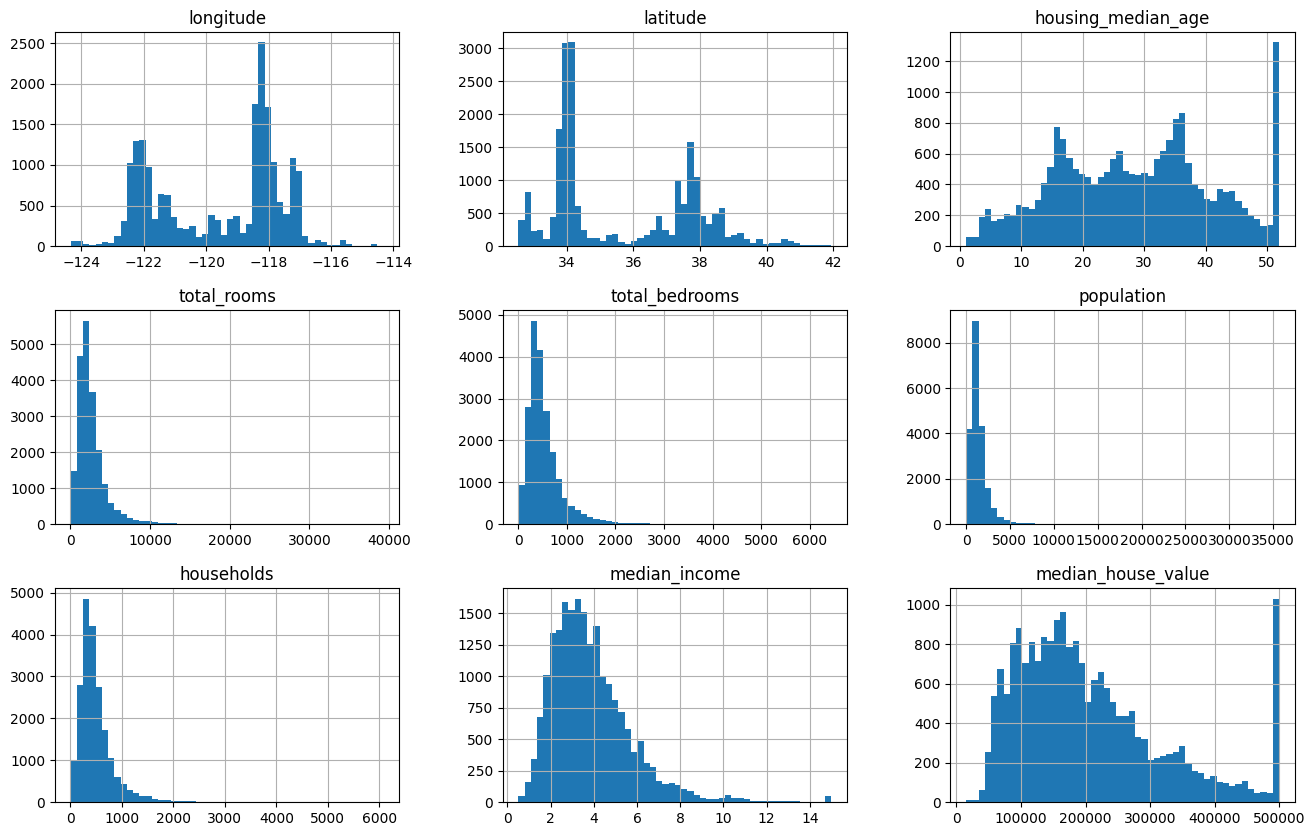

In [11]:
df_num.hist(bins=50,figsize=(16,10))
plt.show()

* total_rooms, total_bedrooms, population, households follow exponential distribution we have to handle outliers.
* Median house value and housing_median_age is capped. We will do binning on median house age.
* Median income is right skewed.
* Houseing median age is multi-modal.

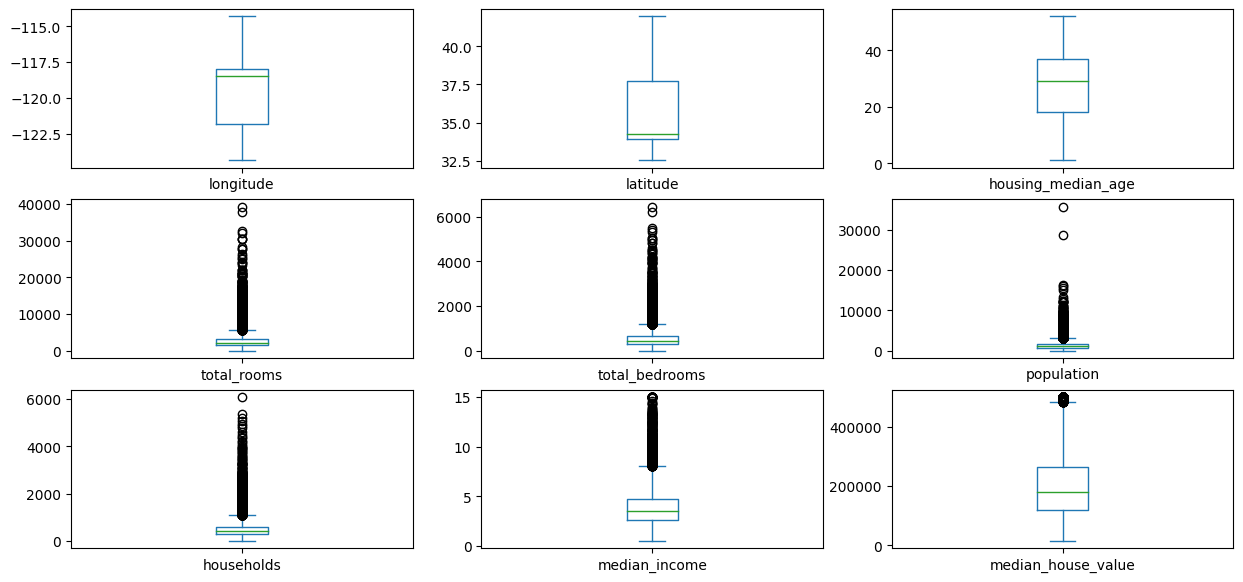

In [12]:
df_num.plot(kind='box', subplots=True, layout=(3,3), figsize=(15,7))
plt.show()

In [13]:
# Most of outlier are important for us so we can remove data bigger than 90% of column
df=df[df['total_rooms']<df['total_rooms'].quantile(0.9)]
df=df[df['total_bedrooms']<df['total_bedrooms'].quantile(0.9)]
df=df[df['population']<df['population'].quantile(0.9)]
df=df[df['households']<df['households'].quantile(0.9)]
df=df[df['median_income']<df['median_income'].quantile(0.9)]

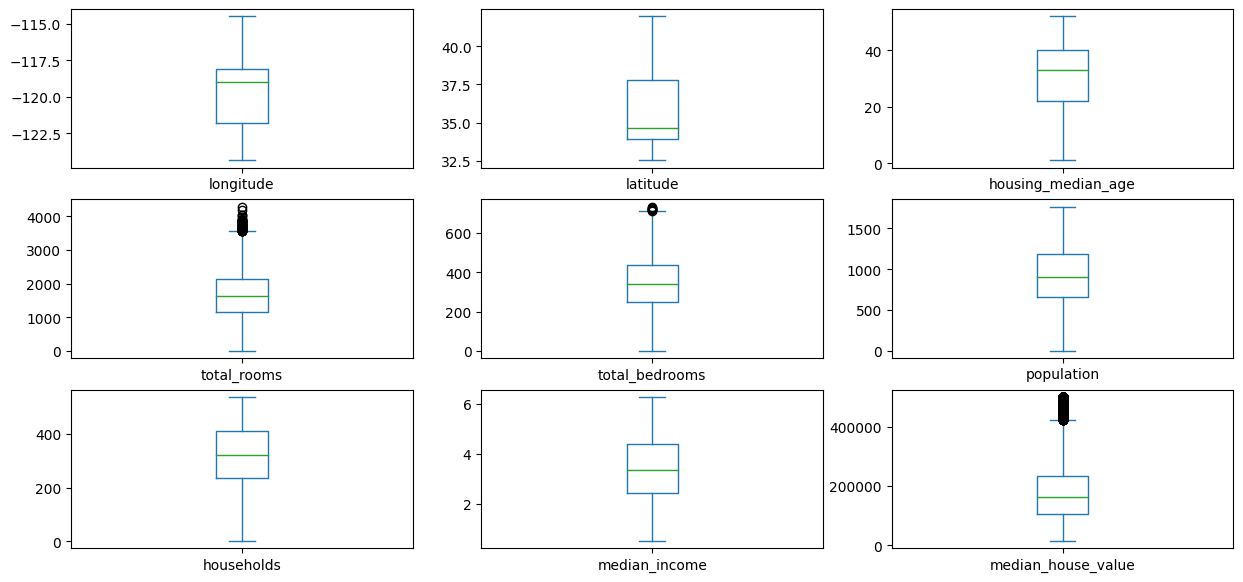

In [14]:
df.plot(kind='box', subplots=True, layout=(3,3), figsize=(15,7))
plt.show()

In [15]:
df_num = df.select_dtypes(include=['float64']).copy()

In [16]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


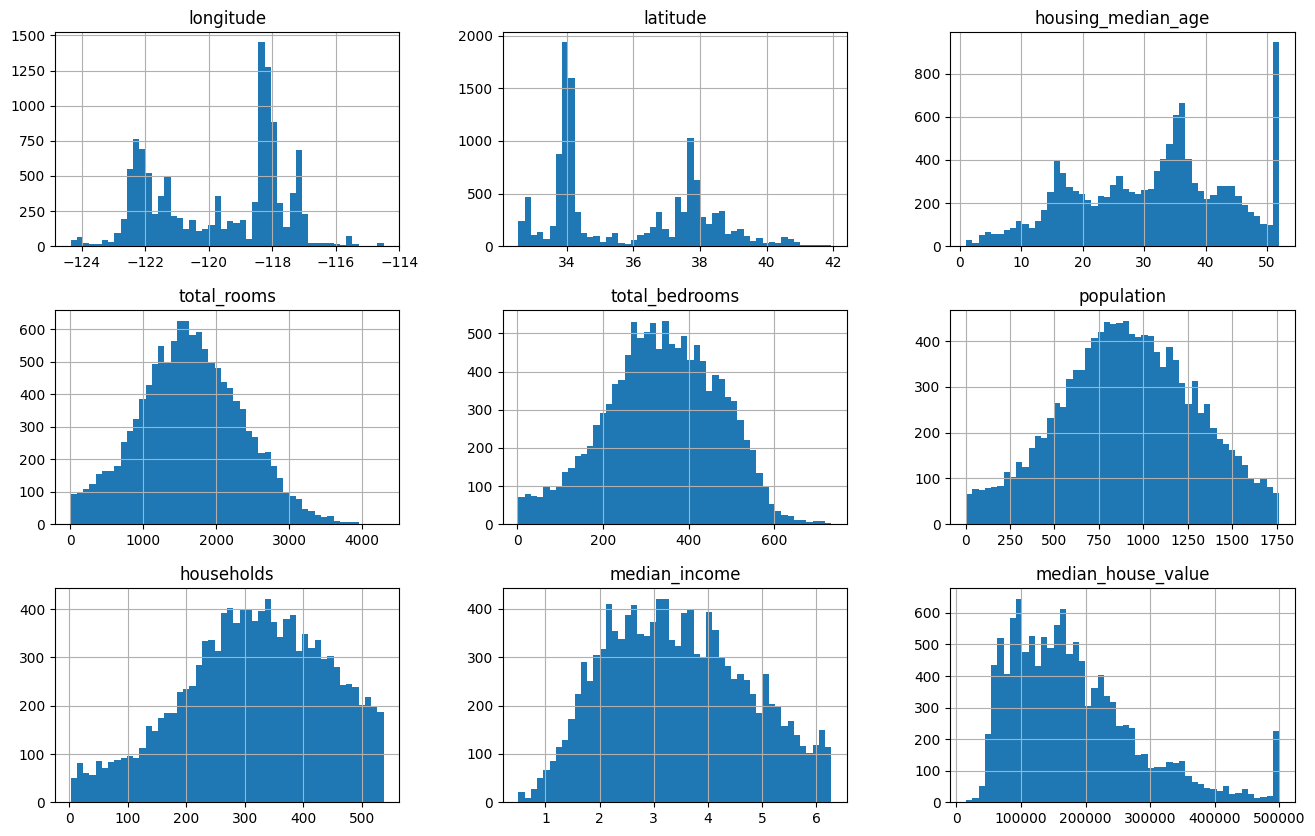

In [17]:
df_num.hist(bins=50,figsize=(16,10))
plt.show()

In [18]:
age = pd.cut(df["housing_median_age"], bins=3, labels=["New", "Young", "Old"])

<Axes: >

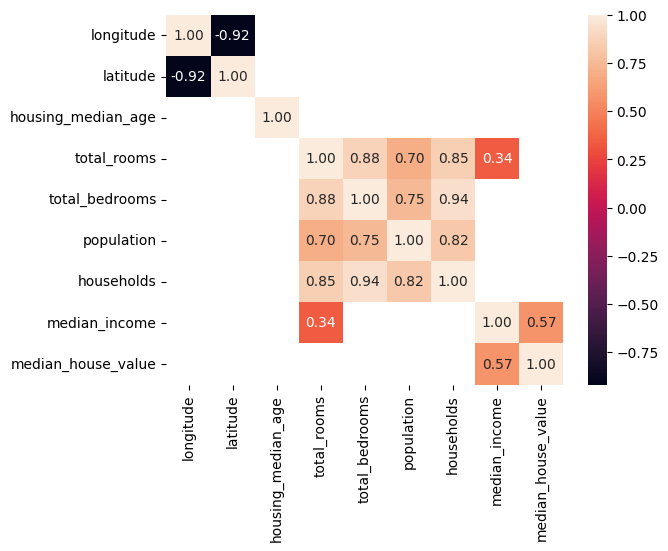

In [19]:
corr_mat= df_num.corr()
mask = (corr_mat<0.25)&(corr_mat>-0.25)
sns.heatmap(corr_mat,annot=True,fmt=".2f",mask=mask)

##### This is corelation matrix for data where data having correlation less than 0.25 and more than -0.25 are masked.
* As some features are very highly correlated. So we have to regularized regression models and can also try performing PCA. As this much correlation can lead to multicollinearity and redundancy.
* Lets first do some feature engineering so that we can average out the effect and may drop the highly correlated features for good.
* We will add columns like bedroom ratio, room_population ratio, room_households ratio, bedroom to population, bedroom to household ratio and finally population to households ratio.
* Latitude and Longitude are very highlt correlated so we will use sin/cos encoding, take product and ratio of them and also take haversine distance(Distance that takes earth curvature in consideration) from San Francisco International Airport (SFO) latitude=37.615223 and longitude = -122.389977.
$$
d = 2R \cdot \arcsin \left( \sqrt{\sin^2 \left(\frac{\Delta \varphi}{2}\right) + \cos(\varphi_1) \cdot \cos(\varphi_2) \cdot \sin^2 \left(\frac{\Delta \lambda}{2}\right) } \right)
$$

**Where:**
- $d$ = Distance between two points  
- $R$ = Earth's radius (6,371 km)  
- $\varphi_1, \varphi_2$ = Latitudes of the two points (in radians)  
- $\lambda_1, \lambda_2$ = Longitudes of the two points (in radians)  
- $\Delta \varphi = \varphi_2 - \varphi_1$ (Latitude difference)  
- $\Delta \lambda = \lambda_2 - \lambda_1$ (Longitude difference)


In [20]:
def haversine_df(df, lat_col, lon_col, ref_lat, ref_lon):
    ref_point = (ref_lat, ref_lon)
    return df.apply(lambda row: haversine(ref_point, (row[lat_col], row[lon_col])), axis=1)

In [21]:
df_ratio = df_num.copy()
airport_lon = -122.389977
airport_lat = 37.615223
def ratio(X,Y):
    return X/(Y+1e-6)
def product(X,Y):
    return X*Y
#df_ratio['longitude_latitude_ratio'] = ratio(df_ratio['longitude'],df_ratio['latitude'])
#df_ratio['longitude_latitude_product'] = product(df_ratio['longitude'],df_ratio['latitude'])
#df_ratio['lon_sin']= np.sin(df_ratio['longitude'])
df_ratio['lon_cos'] = np.cos(df_ratio['longitude'])
df_ratio['lat_sin'] = np.sin(df_ratio['latitude'])
#df_ratio['lat_cos'] = np.cos(df_ratio['latitude'])
df_ratio['distance_from_airport'] = haversine_df(df_ratio,'latitude','longitude',airport_lat,airport_lon)
df_ratio['bedrooms_rooms_ratio'] = ratio(df_ratio['total_bedrooms'],df_ratio['total_rooms'])
df_ratio['Avg_person_per_room']= ratio(df_ratio['population'],df_ratio['total_rooms'])
df_ratio['Rooms_per_household'] = ratio(df_ratio['total_rooms'],df_ratio['households'])
df_ratio['people_per_bedroom'] = ratio(df_ratio['population'],df_ratio['total_bedrooms'])
df_ratio['bedroom_per_household'] = ratio(df_ratio['total_bedrooms'],df_ratio['households'])
df_ratio['household_population_ratio'] = ratio(df_ratio['households'],df_ratio['population'])

<Axes: >

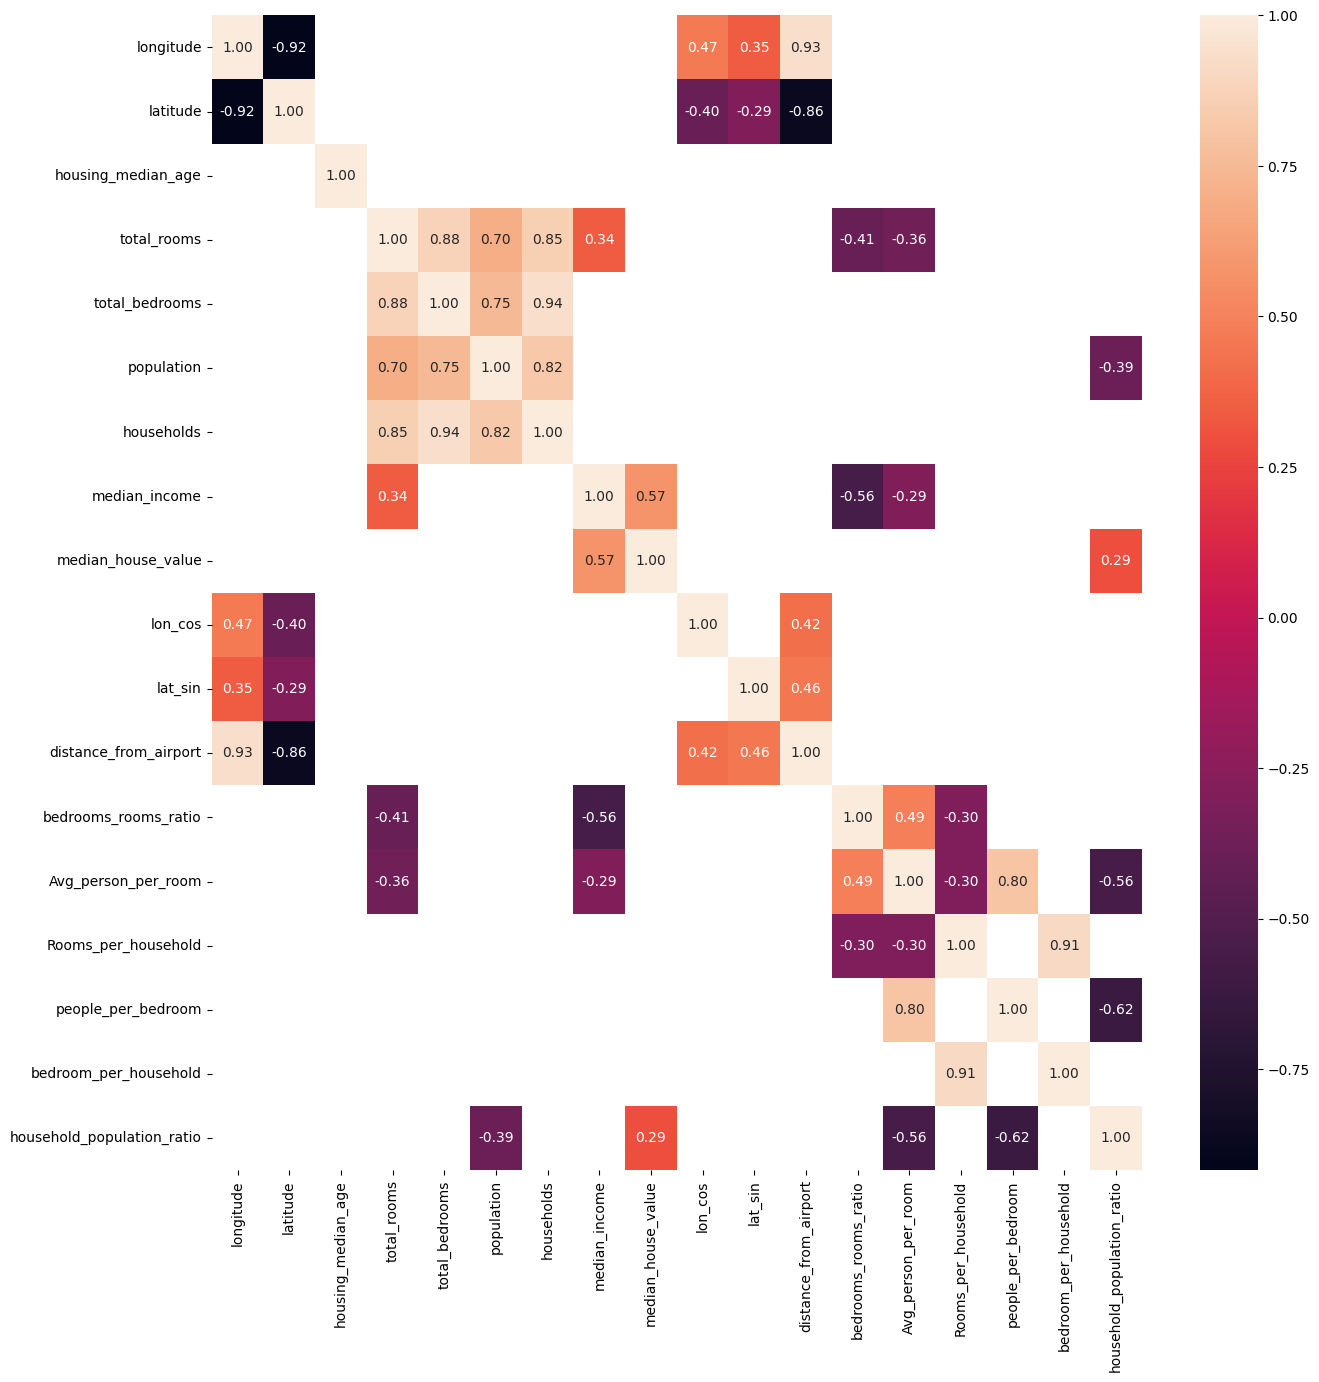

In [22]:
plt.figure(figsize=(15,15))
corr_mat= df_ratio.corr()
mask = (corr_mat<0.25)&(corr_mat>-0.25)
sns.heatmap(corr_mat,annot=True,fmt=".2f",mask=mask)

### Very Beutiful
* There is a subtle relationship between median_income and rooms_perhouehold.
* Avg_person_per_room and people_per_bedroom is highly correlated that means we can drop people_per_bedroom.
* Rooms_per_household and bedroom_per_household both are very highly correlated we can also drop bedroom_per_household.
* There is -0.6 correlation between median_income and bedrooms_room_ratio.

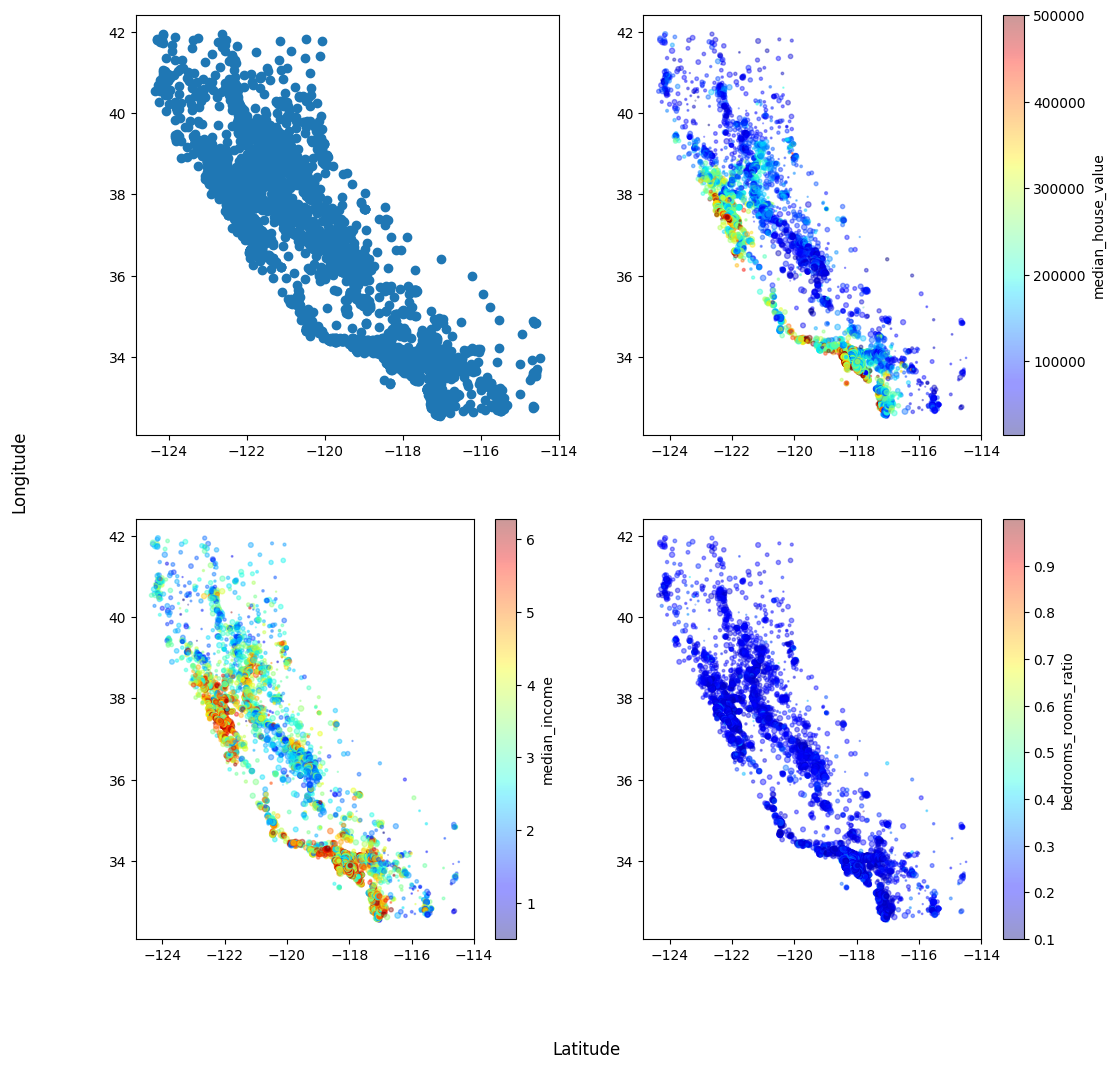

In [23]:
population = df['population']/100
color = plt.get_cmap("jet")
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(12,12))
scatter1 = axs[0,0].scatter(df['longitude'],df['latitude'])
scatter2 = axs[0,1].scatter(df['longitude'],df['latitude'], s= population,
                      label='Population', alpha = 0.4,
            c=df['median_house_value'],cmap=color)
scatter3 = axs[1,0].scatter(df['longitude'],df['latitude'], s= population,
                      label='Population', alpha = 0.4,
            c=df['median_income'],cmap=color)
scatter4 = axs[1,1].scatter(df['longitude'],df['latitude'],s= population,
                      label='Population', alpha = 0.4,
            c=df_ratio['bedrooms_rooms_ratio'],cmap=color)
plt.colorbar(scatter2, label='median_house_value')
plt.colorbar(scatter3, label='median_income')
plt.colorbar(scatter4,label='bedrooms_rooms_ratio')
fig.supxlabel('Latitude')
fig.supylabel('Longitude')
plt.show()

In [24]:
proximity= df.groupby(by='ocean_proximity')


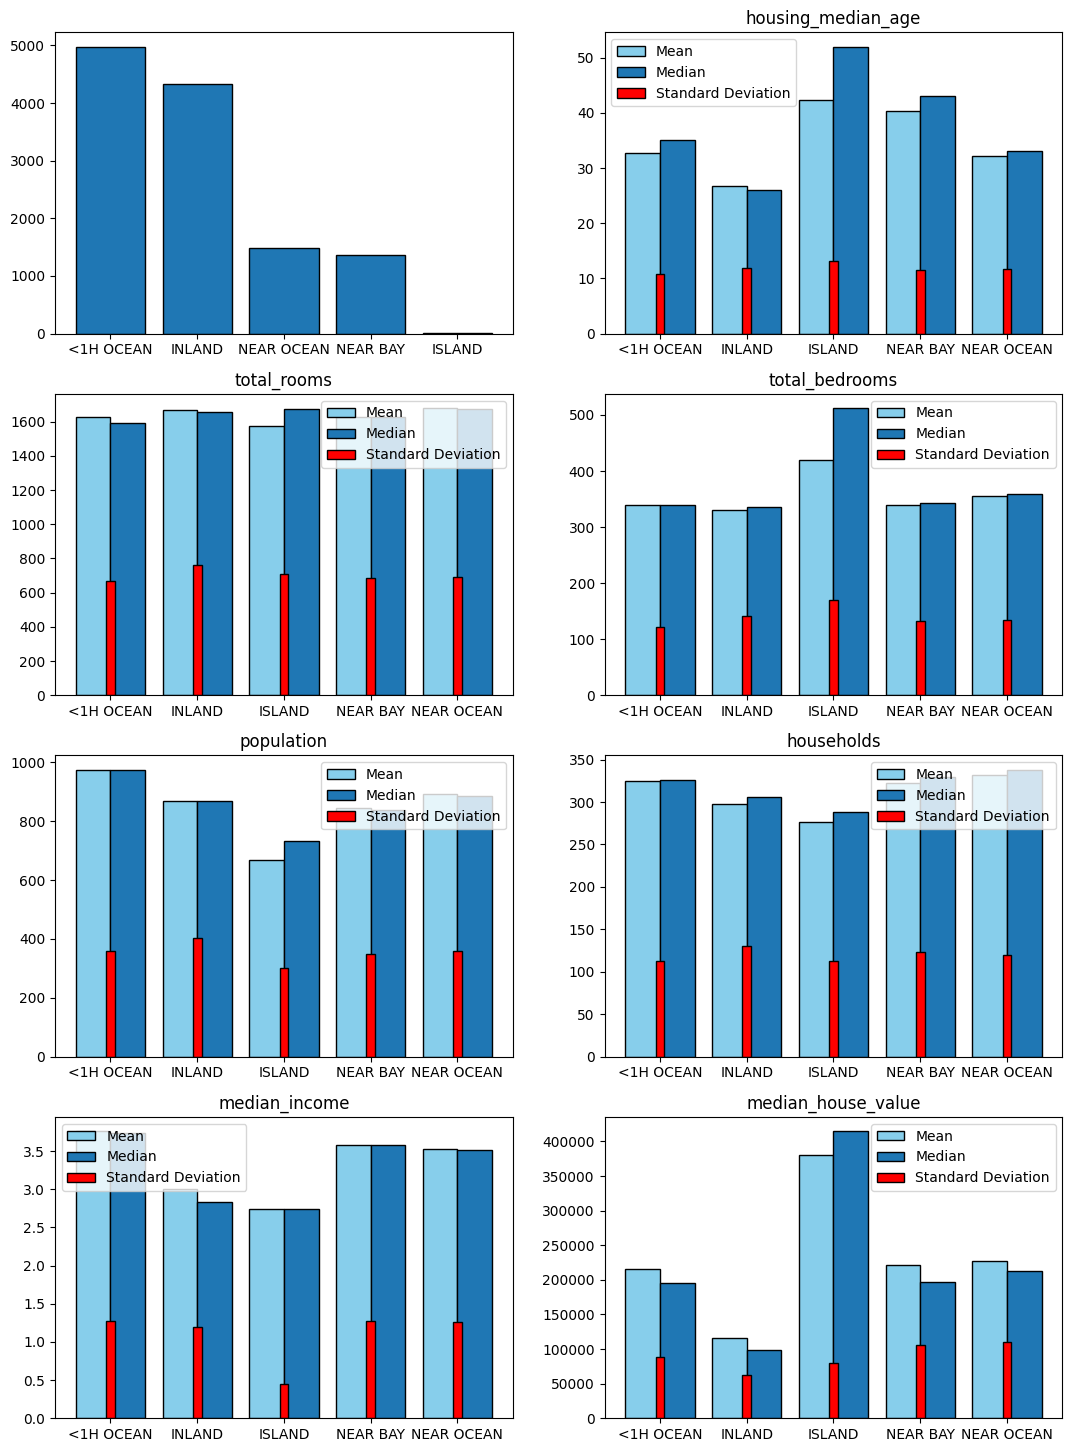

In [25]:
x = np.array([0,1,2,3,4])
x2 = x+0.4
x3 = x +0.2
columns = ['housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value']

fig,axs = plt.subplots(4,2,figsize=(13,18))
avg_price = df['median_house_value'].mean()
axs[0,0].bar(x,df['ocean_proximity'].value_counts(),edgecolor='black')
axs[0,0].set_xticks(x, df['ocean_proximity'].value_counts().index)

k = 0
for i in range(0,4):
    for j in range(0,2):
        col_index = i * 2 + j - 1
        if col_index>=0:
            axs[i,j].bar(x,proximity[columns[k]].mean(),width=0.4,label='Mean',color='skyblue',edgecolor='black')
            axs[i,j].bar(x2,proximity[columns[k]].median(),width=0.4,label='Median',edgecolor='black')
            axs[i,j].bar(x3,proximity[columns[k]].std(),width=0.1,label='Standard Deviation', color="Red",edgecolor='black')
            axs[i,j].legend()
            axs[i,j].set_xticks(x + 0.4 / 2, proximity.mean().index)
            axs[i,j].set_title(columns[k])
            k+=1

plt.show()

In [26]:
import geopandas as gpd
from shapely.geometry import Polygon

def geo_area(df):
    polygon = Polygon(zip(df["longitude"], df["latitude"]))
    gdf = gpd.GeoDataFrame(index=[0], geometry=[polygon], crs="EPSG:4326")
    gdf = gdf.to_crs(epsg=6933)
    area_m2 = (gdf.area[0]).round(2)
    return area_m2

area_dict = {x:geo_area(df[df['ocean_proximity']==x]) for x in df['ocean_proximity'].value_counts().index}

In [27]:
# Convert area_dict to Pandas Series for element-wise division
area_series = pd.Series(area_dict, name="total_land_area")

# Get total number of houses per category
total_houses = df['ocean_proximity'].value_counts()
total_houses.name = "total_houses"

# Get total rooms per category
total_rooms = proximity['total_rooms'].sum()
total_rooms.name = "total_rooms"

#Population
population = proximity['population'].sum()
population.name="population"

# Compute average land area per housing unit
avg_area_housing = area_series / total_houses
avg_area_housing.name = "avg_area_housing"

# Compute average land area per room
avg_area_rooms = area_series / total_rooms
avg_area_rooms.name = "avg_area_rooms"

# Compute ratio of room area to housing area
rooms_to_housing = avg_area_rooms / avg_area_housing
rooms_to_housing.name = "rooms_to_housing"

# People per square meter
area_to_people = area_series/population
area_to_people.name="area_to_people"
# Combine all metrics into a single DataFrame
df_metrics = pd.concat([total_houses, total_rooms, area_series, population,avg_area_housing, avg_area_rooms, rooms_to_housing,area_to_people], axis=1)


# Display the DataFrame
print(df_metrics)


            total_houses  total_rooms  total_land_area  population  \
<1H OCEAN           4978    8094551.0     2.823572e+10   4850817.0   
INLAND              4333    7218252.0     1.126216e+11   3763037.0   
NEAR OCEAN          1491    2502974.0     5.980343e+10   1332641.0   
NEAR BAY            1357    2211822.0     1.816906e+09   1146751.0   
ISLAND                 5       7873.0     7.227040e+06      3340.0   

            avg_area_housing  avg_area_rooms  rooms_to_housing  area_to_people  
<1H OCEAN       5.672102e+06     3488.238337          0.000615     5820.818043  
INLAND          2.599160e+07    15602.336566          0.000600    29928.378893  
NEAR OCEAN      4.010961e+07    23892.950776          0.000596    44875.877730  
NEAR BAY        1.338914e+06      821.452315          0.000614     1584.394784  
ISLAND          1.445408e+06      917.952510          0.000635     2163.784464  


* Avg_area_to_people = (Land_area/number of housing)/population
* Avg_area_rooms = avg_area_rooms*no. of rooms
* rooms_to_housing_ratio

In [28]:
df_ratio['avg_area_to_people'] = df['ocean_proximity'].map(area_dict) / (
    df['ocean_proximity'].map(df['ocean_proximity'].value_counts()) * df['population']
)
df_ratio['avg_room_area'] = df['ocean_proximity'].map(area_dict)*df['total_rooms'] / df['ocean_proximity'].map(proximity['total_rooms'].sum())

<Axes: >

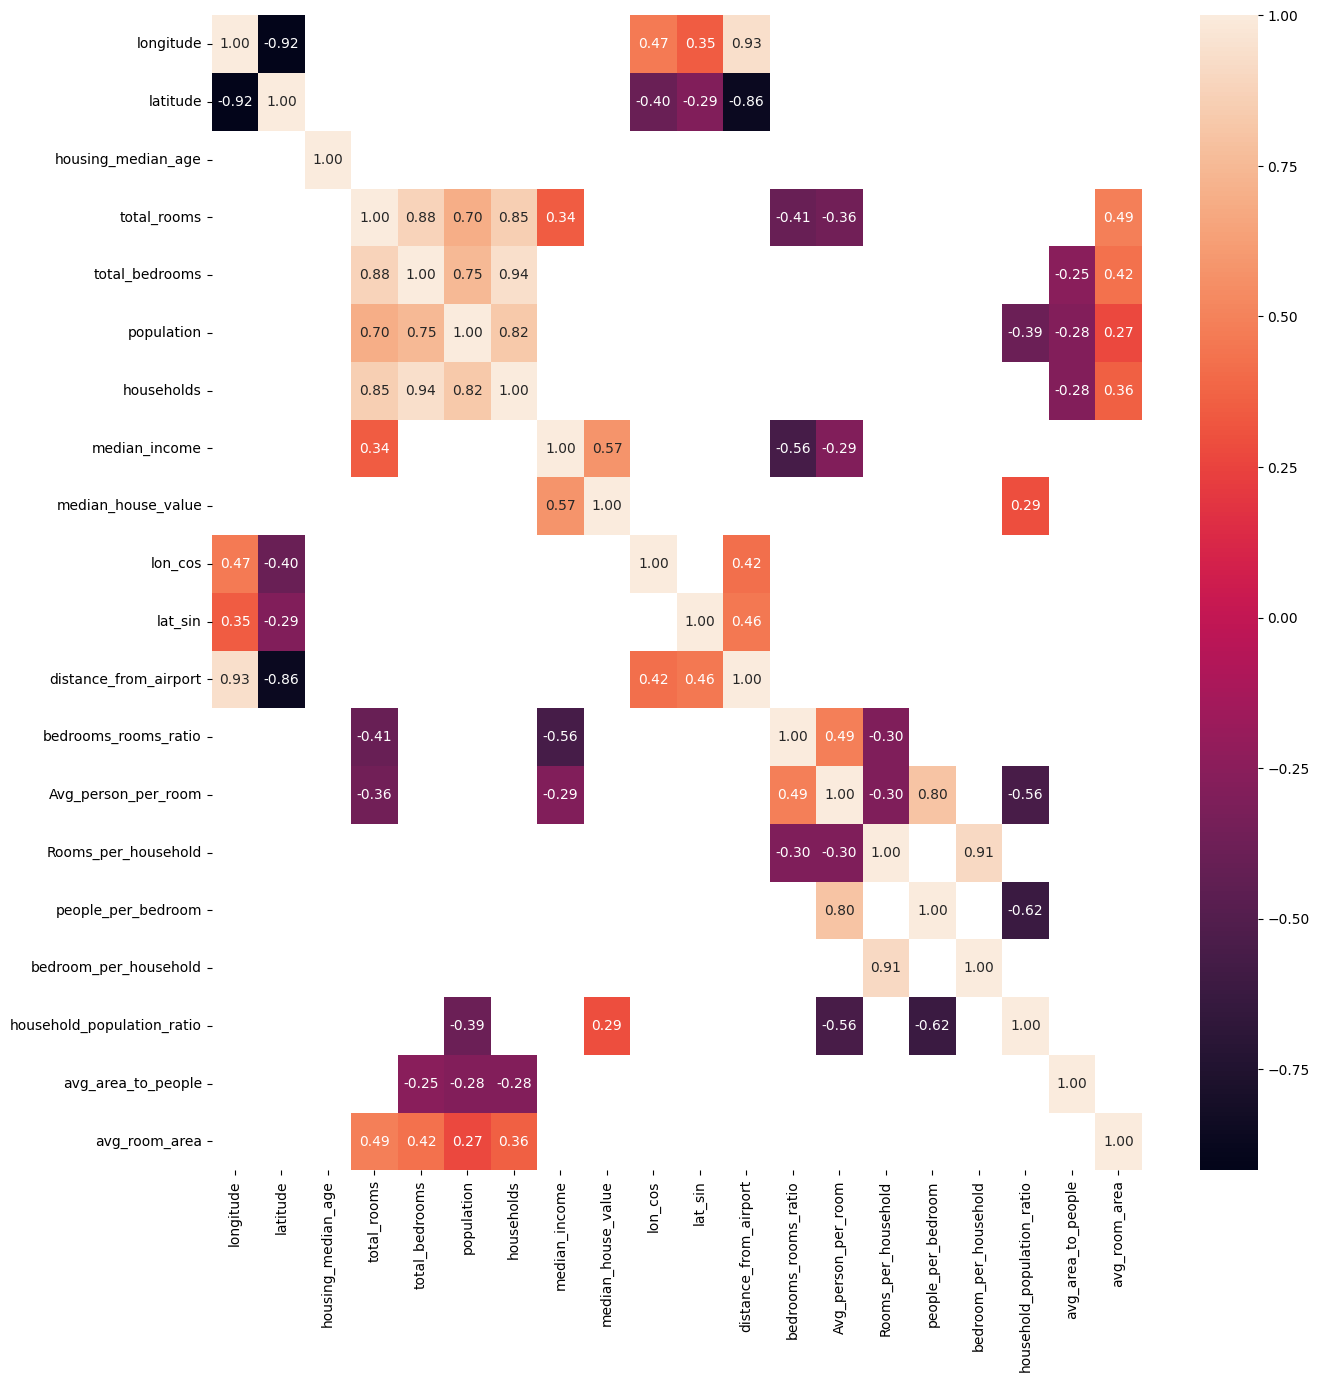

In [29]:
plt.figure(figsize=(15,15))
corr_mat= df_ratio.corr()
mask = (corr_mat<0.25)&(corr_mat>-0.25)
sns.heatmap(corr_mat,annot=True,fmt=".2f",mask=mask)

In [30]:
y = df['median_house_value']
x = df.drop(columns=['median_house_value'])

In [31]:
x_train , x_test , y_train , y_test = train_test_split(x,y , test_size= 0.25 , random_state=42)

In [32]:
x_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
16265,-121.27,37.96,41.0,461.0,101.0,382.0,79.0,1.2750,INLAND
14877,-117.09,32.63,33.0,620.0,161.0,420.0,164.0,1.8417,NEAR OCEAN
6505,-118.06,34.08,34.0,1197.0,260.0,942.0,245.0,3.4202,<1H OCEAN
11071,-117.85,33.83,26.0,1904.0,292.0,945.0,303.0,5.6784,<1H OCEAN
15259,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826,NEAR OCEAN


In [33]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from scipy.stats import randint
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [34]:
airport_lon = -122.389977
airport_lat = 37.615223
def ratio(X,Y):
    return X/(Y+1e-6)
def product(X,Y):
    return X*Y

class FeatureAdderRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        airport_lon = -122.389977
        airport_lat = 37.615223
        X_new = X.copy()
        X_new['lon_cos'] = np.cos(X_new['longitude'])
        X_new['lat_sin'] = np.sin(X_new['latitude'])
        X_new['distance_from_airport'] = haversine_df(X_new,'latitude','longitude',airport_lat,airport_lon)
        X_new['bedrooms_rooms_ratio'] = ratio(X_new['total_bedrooms'],X_new['total_rooms'])
        X_new['Avg_person_per_room']= ratio(X_new['population'],X_new['total_rooms'])
        X_new['Rooms_per_household'] = ratio(X_new['total_rooms'],X_new['households'])
        X_new['people_per_bedroom'] = ratio(X_new['population'],X_new['total_bedrooms'])
        X_new['bedroom_per_household'] = ratio(X_new['total_bedrooms'],X_new['households'])
        X_new['household_population_ratio'] = ratio(X_new['households'],X_new['population'])
        X_new['avg_area_to_people'] = X_new['ocean_proximity'].map(area_dict) / (
        X_new['ocean_proximity'].map(X_new['ocean_proximity'].value_counts()) * X_new['population']
        )
        X_new['avg_room_area'] = X_new['ocean_proximity'].map(area_dict)*X_new['total_rooms'] / X_new['ocean_proximity'].map(X_new.groupby(by='ocean_proximity')['total_rooms'].sum())
        X_new.drop(['longitude','latitude'], axis = 1, inplace = True)
        
        return X_new

In [35]:
ohe = OneHotEncoder(drop="first",sparse_output=False)
rbs = RobustScaler()
std = StandardScaler()
transformer = ColumnTransformer([
    ("onehot",ohe,['ocean_proximity']),
    ("robust",rbs,['avg_area_to_people','avg_room_area']),
    ("standard",std,['housing_median_age','total_rooms','total_bedrooms','population',
                              'households','median_income','distance_from_airport','Rooms_per_household',
                              'people_per_bedroom','bedroom_per_household'])
],remainder='passthrough')

In [36]:
feature_adder_remover = FeatureAdderRemover()
pipeline = Pipeline([
    ("add_remove_feature",feature_adder_remover),
    ("transform",transformer)
])

In [37]:
X_t=pipeline.fit_transform(x_train)

In [38]:
X_trns = pd.DataFrame(X_t,columns = pipeline[-1].get_feature_names_out())

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmse_score(estimator, X, y):
    y_pred = estimator.predict(X)
    return np.sqrt(mean_squared_error(y, y_pred))

def mae_score(estimator, X, y):
    y_pred = estimator.predict(X)
    return mean_absolute_error(y, y_pred)

def r2_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return r2_score(y, y_pred)

In [40]:
from sklearn.linear_model import LinearRegression
lnr = LinearRegression()
lnr_cross_val_rmse = cross_val_score(lnr,X_trns,y_train,scoring=rmse_score,cv=15)
lnr_cross_val_mae = cross_val_score(lnr,X_trns,y_train,scoring=mae_score,cv=15)

print("lnr_mean=",lnr_cross_val_rmse.mean().round(2), "lnr_std",lnr_cross_val_rmse.std().round(2))
print("lnr_mean=",lnr_cross_val_mae.mean().round(2), "lnr_std",lnr_cross_val_mae.std().round(2))


lnr_mean= 64955.78 lnr_std 2898.36
lnr_mean= 46530.92 lnr_std 1531.48


In [41]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.5)
ridge_cross_val = cross_val_score(ridge,X_trns,y_train,scoring=rmse_score,cv=5).mean()
print("ridge_mean=",ridge_cross_val.mean().round(2), "ridge_std",ridge_cross_val.std().round(2))

ridge_mean= 65029.97 ridge_std 0.0


In [42]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso_cross_val = cross_val_score(lasso,X_trns,y_train,scoring=rmse_score,cv=5).mean()
print("lasso_mean",lasso_cross_val.mean().round(2), "lasso_std",lasso_cross_val.std().round(2))

lasso_mean 65046.17 lasso_std 0.0


In [43]:
lasso.fit(X_trns,y_train)

Lasso()

In [44]:
lasso.coef_

array([-67618.81840693, 123803.46912089, -12774.25305269,  12350.28482523,
          311.05769036,   -294.20167256,  11107.15066025, -13890.5401724 ,
        21009.39344845, -14121.2382619 ,   5379.59043044,  55183.60609655,
        -6209.69716663,  27807.1010341 , -11115.85257073, -25278.34103257,
         5758.5354189 ,   -885.55587655, 101284.52611151,  48839.49380914,
       192511.30736609])

In [45]:
from sklearn.ensemble import RandomForestRegressor
rnd= RandomForestRegressor(random_state=42)
#rnd_cross_val_mae = cross_val_score(rnd,X_trns,y_train,scoring=mae_score,cv=5).mean()
#rnd_cross_val_r2 = cross_val_score(rnd,X_trns,y_train,scoring=r2_scorer,cv=5).mean()
#print("rnd_mean",rnd_cross_val_rmse.mean().round(2),"rnd_std",rnd_cross_val_rmse.std().round(2))
#print("rnd_mean",rnd_cross_val_mae.mean().round(2),"rnd_std",rnd_cross_val_mae.std().round(2))
#print("rnd_mean",rnd_cross_val_r2.mean().round(2),"rnd_std",rnd_cross_val_r2.std().round(2))

In [46]:
rnd_bayes = RandomForestRegressor()
param_dist = {
    "n_estimators": Integer(1,1000),
    "max_depth": Integer(1,1000),
    "min_samples_split":Integer(2,200),
    "min_samples_leaf":Integer(1,200),
    "random_state":Integer(1,1000),
    "max_features": Real(0.1, 1.0, "uniform")
    
}
bayes_search = BayesSearchCV(rnd_bayes,search_spaces=param_dist,n_iter=20,
                   scoring='neg_mean_squared_error',n_jobs=-1,cv=5,random_state=42,return_train_score=True)

In [47]:
#bayes_search.fit(X_trns,y_train)

In [48]:
best_params1 = {'max_depth': 2,
 'min_samples_leaf': 134,
 'min_samples_split': 55,
 'n_estimators': 106,
 'random_state': 772}

best_params = {'max_depth': 1000,
             'max_features': 0.46060707641143983,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 1000,
             'random_state': 1}
#bayes_search.best_params_

In [49]:
from sklearn.ensemble import RandomForestRegressor
rnd= RandomForestRegressor(**best_params)
rnd_cross_val_rmse = cross_val_score(rnd,X_trns,y_train,scoring=rmse_score,cv=20).mean()
print("rnd_mean",rnd_cross_val_rmse.mean().round(2),"rnd_std",rnd_cross_val_rmse.std().round(2))

rnd_mean 49317.39 rnd_std 0.0


In [50]:
final_pipeline = Pipeline([
    ("tranformation",pipeline),
    ("model",rnd)
])

In [51]:
final_pipeline.fit(x_train,y_train)

Pipeline(steps=[('tranformation',
                 Pipeline(steps=[('add_remove_feature', FeatureAdderRemover()),
                                 ('transform',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False),
                                                                   ['ocean_proximity']),
                                                                  ('robust',
                                                                   RobustScaler(),
                                                                   ['avg_area_to_people',
                                                                    'avg_room_area']),
                                                                  ('standard',
                                                                   StandardScaler(),
                                                                   ['housing_median_age',
                                                                    'total_rooms',
                                                                    'total_bedrooms',
                                                                    'population',
                                                                    'households',
                                                                    'median_income',
                                                                    'distance_from_airport',
                                                                    'Rooms_per_household',
                                                                    'people_per_bedroom',
                                                                    'bedroom_per_household'])]))])),
                ('model',
                 RandomForestRegressor(max_depth=1000,
                                       max_features=0.46060707641143983,
                                       n_estimators=1000, random_state=1))])

In [52]:
y_pred = final_pipeline.predict(x_test)

In [53]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAE = mean_absolute_error(y_test, y_pred)
R2_score = r2_score(y_test, y_pred)

In [54]:
Results = pd.DataFrame({
    "Score":[RMSE,MAE,R2_score]
},index=["RMSE", "MAE", "R2_Score"])
Results

,Score
RMSE,50311.925756
MAE,33637.121441
R2_Score,0.746207
